In [189]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sns
from pandas.core.nanops import nanmean as pd_nanmean
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
import itertools
from sklearn.metrics import r2_score
from math import factorial

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.layouts import gridplot
matplotlib.style.use('ggplot')

In [190]:
df = pd.read_excel("training.xlsx")
df = df.set_index('Date', 'Value')
df1 = pd.read_excel('training.xlsx', index_col=[0], names=['date', 'val'])

In [172]:
def std_dev(x, freq): #среднеквадраичное отклонение
    b = np.asanyarray(x)
    return np.array([(b[i]-np.std(b[i:freq+i])) for i in range(len(x)-freq)])

def series_seasonal(df, window):
    seasonal = np.array([pd_nanmean(df[i::window], axis=0)
                         for i in range(window)])
    return seasonal

def seasonal_mean(x, freq):
    """
    Return means for each period in x. freq is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::freq]) for i in range(freq)])

def series_decompose_sum(df, window):  # Аддитивная модель
    avg = df.Value.rolling(window=30).mean()  # trend, но по-другому
    no_trend = df.Value - avg
    seasonal = series_seasonal(no_trend, 30)
    seasonal = seasonal - np.mean(seasonal, axis=0)
    size = no_trend.shape[0]
    season = np.tile(seasonal.T, size // window + 1).T[:size]  # window = 30
    df['Season1'] = season
    sea_son = df.Season1
    residual = df.Value - avg - season
    return avg, sea_son, residual


def series_decompose_mul(df, window):  # Мультипликативная модель
    avg = df.Value.rolling(window=30).mean()  # trend, но по-другому
    no_trend = df.Value/avg
    seasonal = series_seasonal(no_trend, 30)
    seasonal = seasonal - np.mean(seasonal, axis=0)
    size = no_trend.shape[0]
    season = np.tile(seasonal.T, size // window + 1).T[:size]  # window = 30
    df['Season2'] = season
    sea_son = df.Season2
    residual = df.Value - avg - season
    return avg, sea_son, residual

In [173]:
def plotMovingAverage(series, n):
    from statsmodels.tsa.seasonal import seasonal_decompose

    stand_dev = std_dev(series, n).squeeze() #данные исходной серии за вычетом сколзящего среднеквадратичного
    rolling_mean = series.rolling(window=n, center=True).mean() #скользящая средняя
    
    detrended = series-rolling_mean #убрали тренд
    period_averages = seasonal_mean(detrended, n)#усреднили
    period_averages -= np.mean(period_averages)#??????
    seasonal = np.tile(period_averages, len(series)//n + 1)[:len(series)] #расширили массив, чтобы по размерности совпадал с исходными данными
    detrended= np.asanyarray(detrended).squeeze()
    resid = detrended-seasonal#шум
    
    detrended_multi = series/rolling_mean #дальше все то же самое, но для мультипликативной модели
    period_averages_multi = seasonal_mean(detrended_multi, n)
    period_averages_multi /= np.mean(period_averages_multi)
    seasonal_multi = np.tile(period_averages_multi, len(series) //n + 1)[:len(series)]
    detrended_multi = np.asanyarray(detrended_multi).squeeze()
    resid_multi = detrended_multi/seasonal_multi
    
    #рисуем красиво
    p = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  
    
    p.line(
    source = series, x = 'date', y = 'val', color = 'black', legend = 'Observed'
    ) 
    p.line(
    x = series.index, y = stand_dev, color = 'purple', legend = 'Std deviation'
    )
    
    p1 = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  
    p1.line(
    source = rolling_mean, x = 'date', y = 'val', color = 'magenta', legend = 'Trend'
    )
    
    p2 = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  
    p2.line(
    x = series.index, y = seasonal_multi, color = 'cyan', legend = 'Seasonal Multi'
    )

    p3 = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  

    p3.line(
    x = series.index, y = resid_multi, color = 'orange', legend = 'Residual Multi'
    ) 
    
    p4 = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  
    p4.line(
    x = series.index, y = seasonal, color = 'maroon', legend = 'Seasonal Add'
    )
    
    p5 = figure(
        plot_width = 400,
        plot_height = 400, x_axis_type = 'datetime'
    )  

    p5.line(
    x = series.index, y = resid, color = 'blue', legend = 'Residual Add'
    ) 
    
    grid = gridplot([p, p1, p2, p3, p4, p5], ncols=3)
    show(grid)

In [174]:

plotMovingAverage(df,12)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
print('ВЫВОД: Временной ряд не является стационарным, так как его математическое ожидание и дисперсия зависят от времени')

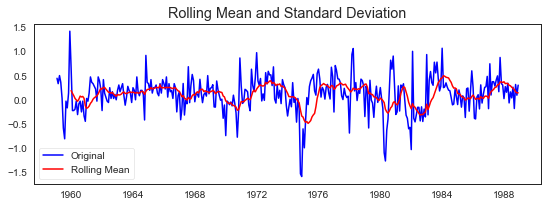

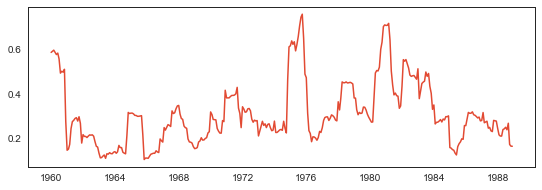

Итак, мы получили, что первые разности ряда стационарны, значит он является интегрируемым рядом первого порядка. Определен параметр для ARIMA(p,d,q) : d = 1


In [187]:
#Выясним порядок интегрированности нашего ряда, начнем с дифференцирования первого порядка.
rcParams['figure.figsize'] = 12, 5
sample = df.Value - df.Value.shift(1)
sample.dropna(inplace=True)
# test_stationarity(sample_data_diff, window = 48)
# Determing rolling statistics
timeseries = sample
rolmean = timeseries.rolling(12).mean()
rolstd = timeseries.rolling(12).std()

# Plot rolling statistics:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(321, label='Rolling Std')

orig = plt.plot(timeseries, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()


fig = plt.figure(figsize=(20, 10), num='Time Series Decomposition')
ax = fig.add_subplot(321, label='Rolling Std')

sns.lineplot(data=rolstd, ax=ax)

plt.show()
print('Итак, мы получили, что первые разности ряда стационарны, значит он является интегрируемым рядом первого порядка. Определен параметр для ARIMA(p,d,q) : d = 1')

ARIMA(p,d,q) : q = 3 - номер последнего несезонного лага, при котором автокорреляция значима.
ARIMA(p,d,q) : p = 1 - номер последнего несезонного лага, при котором частичная автокорреляция значима


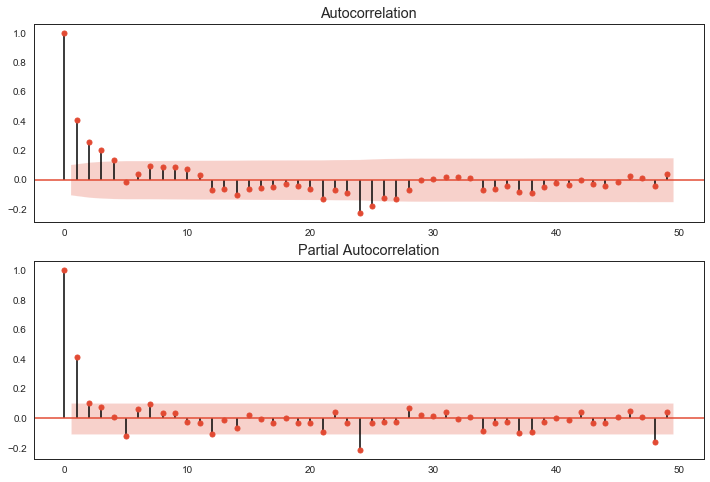

In [188]:
# построим автокорреляцию и частичную автокорреляцию ряда
traindiff = df.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(traindiff.values.squeeze(), lags=49, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(traindiff, lags=49, ax=ax2)
print('ARIMA(p,d,q) : q = 3 - номер последнего несезонного лага, при котором автокорреляция значима.')
print('ARIMA(p,d,q) : p = 1 - номер последнего несезонного лага, при котором частичная автокорреляция значима')

In [ ]:
print('Еще один способ нахождения параметров p и q, поиска по сетке для выбора модели, перебирающий различные комбинации параметров:')
p = q = range(0, 10)
d = 1
pq = list(itertools.product(p, q))
models = {}

warnings.filterwarnings("ignore")
pq
for param in pq:
    try:
        param = list(param)
        param.insert(1, 1)
        param = tuple(param)
        model = sm.tsa.ARIMA(df.Value, order=param).fit()
        models[param] = model.aic
    except BaseException:
        continue
models = sorted(models.items(), key=lambda x: x[1])
best_models=models[:3]
#берем три наилучние модели по критерию акаике


In [175]:
def arima_call(train, order, test):
    model = sm.tsa.ARIMA(train.Value.squeeze(), order=order, freq='MS').fit()
    y_r = model.predict(start=train.shape[0],
                        end=train.shape[0]+test.shape[0]-1, typ='levels')
    
    plt.figure(figsize=(20, 10))
    ax = sns.lineplot(train.index, train.Value, label='Train', color='#98248F')
    ax = sns.lineplot(test.index, test.Value, label='Test')
    ax = sns.lineplot(y_r.index, y_r, label='ARIMA')
    plt.legend(loc='best')
    
    
    print('Score: {}'.format(r2_score(test.Value, y_r)))
    print('Aiс: {}'.format(model.aic))
    plt.show()
    return model.aic

Score: -3.3206742418867456
Aiс: 251.08321143936564


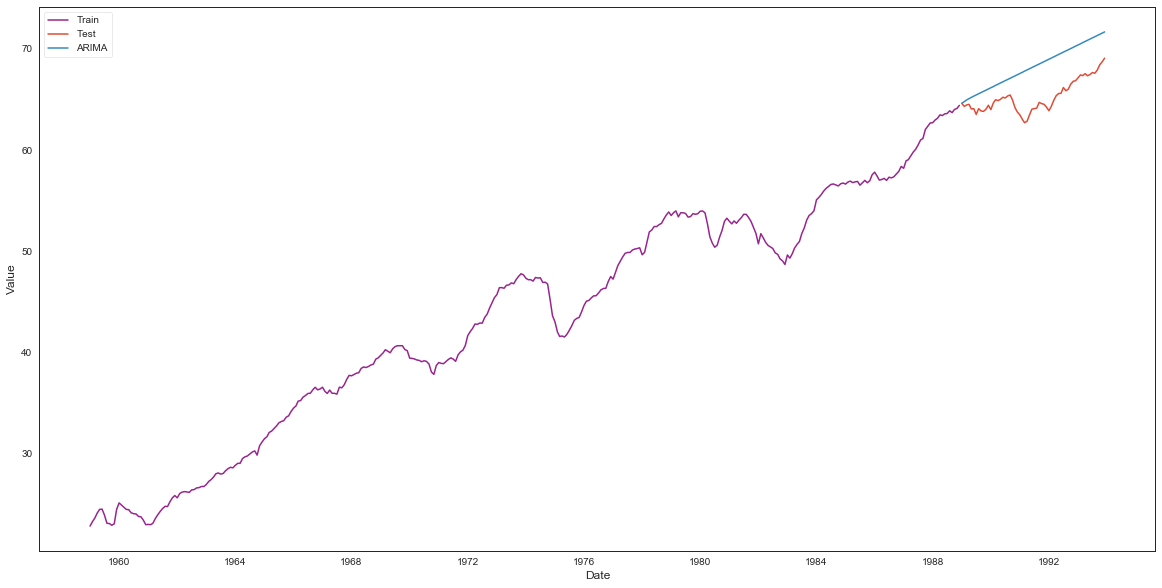

251.08321143936564

In [176]:
dt = pd.read_excel("testing.xlsx",columns=['Date', 'Value'])
dt = dt.set_index('Date')
df = pd.read_excel('training.xlsx')

df.sort_values('Date', axis=0, inplace=True)
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df.Date
df.drop('Date', axis=1, inplace=True)
df.head()

arima_call(df, (1, 1, 3), dt)

Score: -3.281336802817572
Aiс: 248.73365724475104


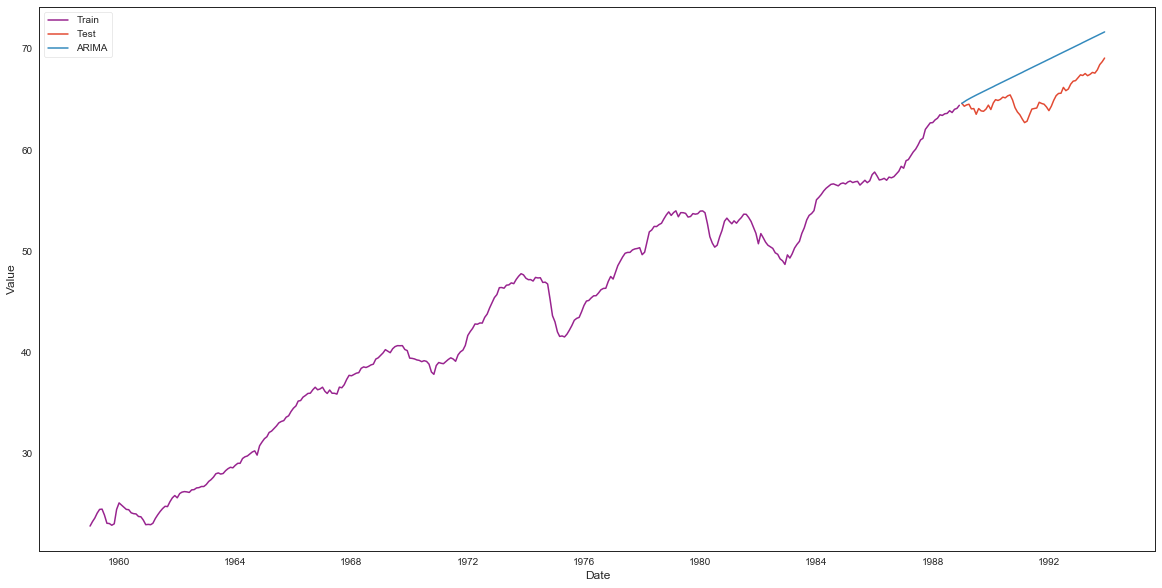

248.73365724475104

In [177]:
# оптимальная по aic с учетом ограничений q + p <= 2
arima_call(df, (1, 1, 1), dt)

In [178]:
print("ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.")

ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.


Score: -4.019166196992575
Aiс: 241.222488923166


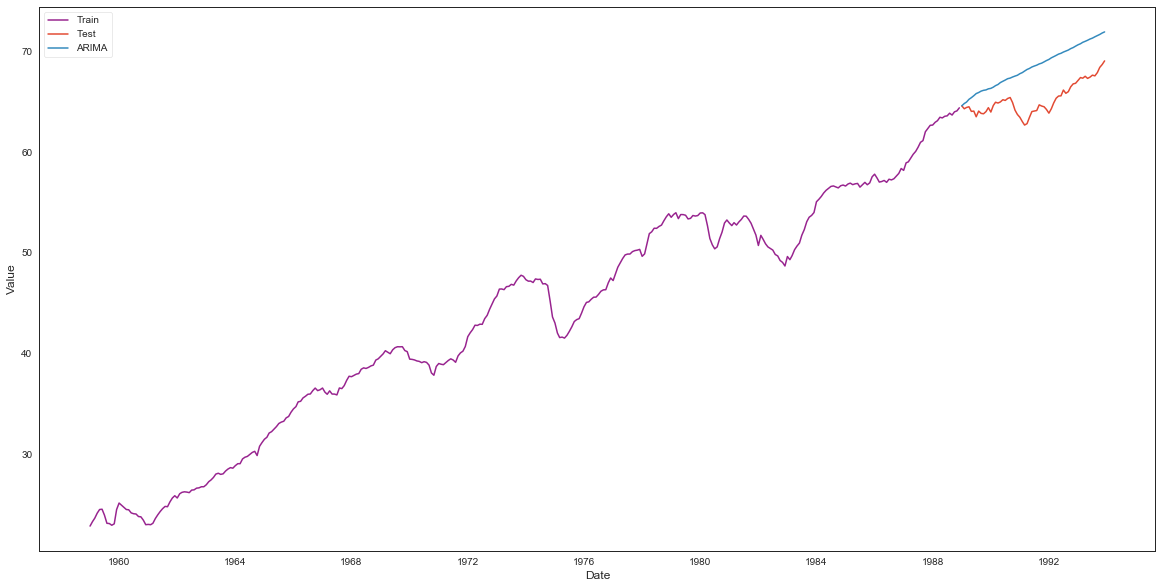

241.222488923166

In [179]:
# оптимальная по aic без ограничений на параметры
arima_call(df, (9, 1, 4), dt)

Score: 0.020430959776812307
Aiс: 248.79216938699608


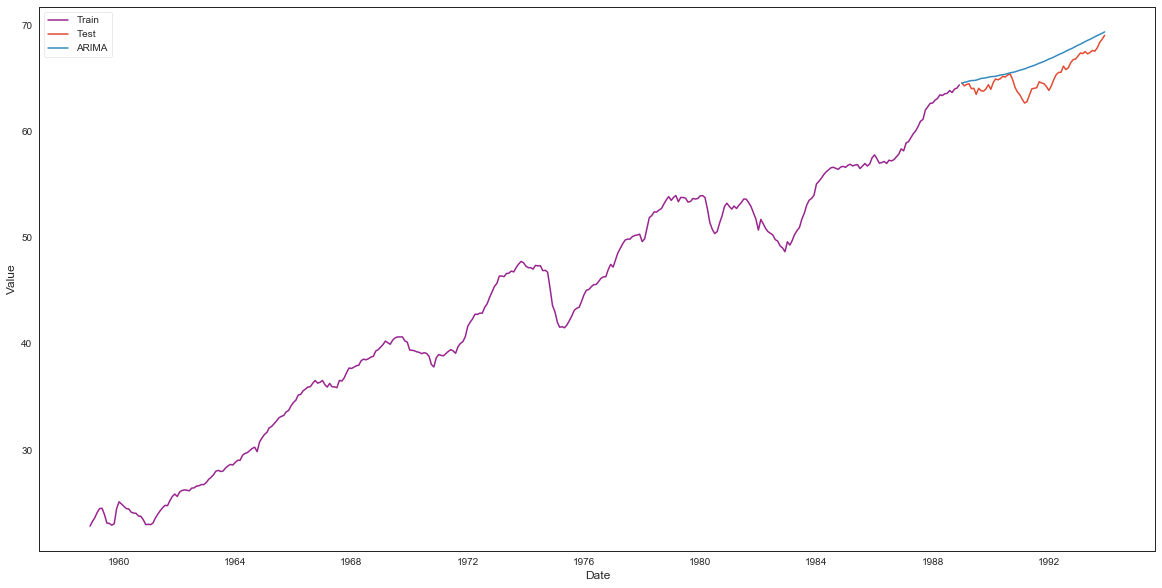

248.79216938699608

In [181]:
# визуально подходящая
arima_call(df, (12, 1, 3), dt)

Score: -4.019166196992575
Aiс: 241.222488923166


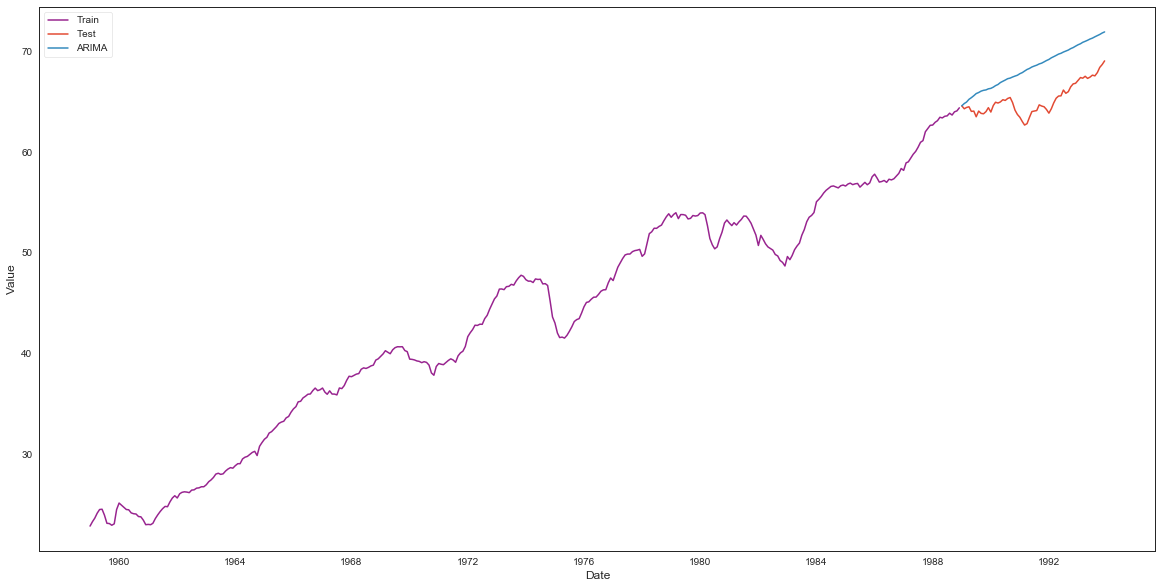

Score: -3.134568181544502
Aiс: 242.74226232115598


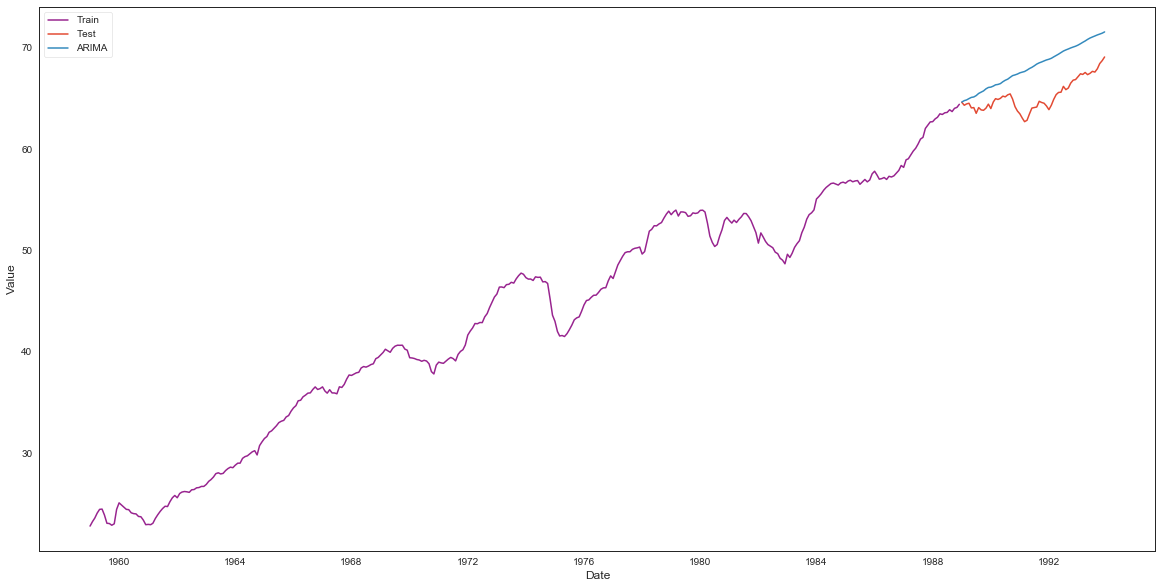

Score: -3.7757528136594845
Aiс: 243.3907058373045


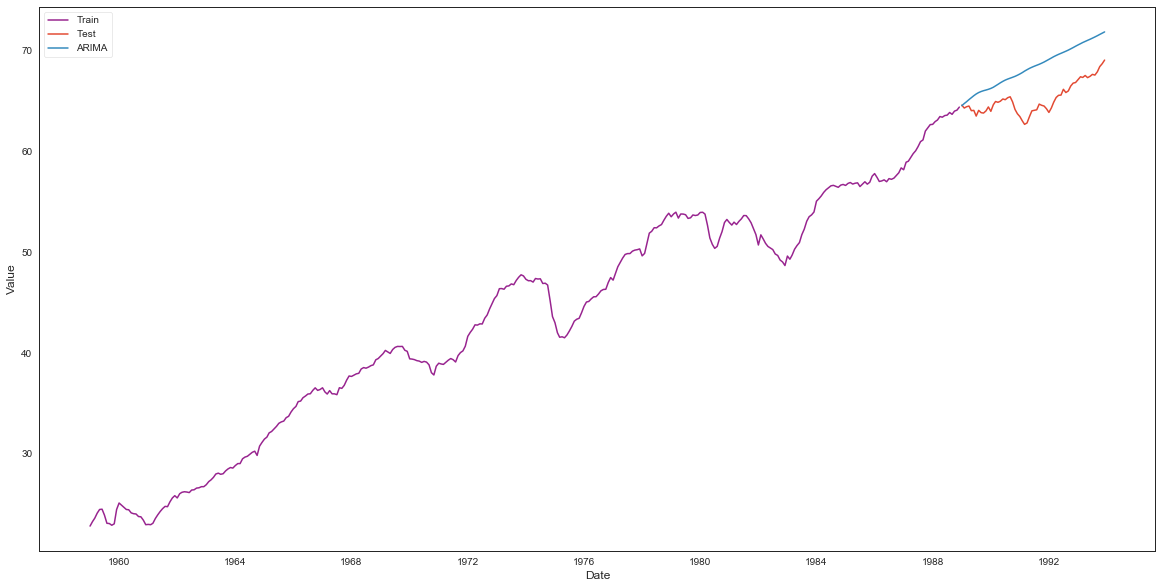

In [183]:
#теперь проверим наши три модели, найденные по сетке
best_model = [((9, 1, 4), 241.22248892342589),
 ((8, 1, 6), 242.74185597043345),
 ((8, 1, 2), 243.39070584191631)]
for i in best_model:
    arima_call(df, i[0], dt)

In [ ]:

print('ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.')